In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
from tqdm import tqdm
import os
import cv2
import matplotlib.pyplot as plt

In [4]:
data_dir="./data/"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

all_train_subdir=glob.glob(train_dir+"/*")
all_test_subdir=glob.glob(test_dir+"/*")

In [6]:
train_classes=[os.path.basename(pp) for pp in all_train_subdir]
test_classes=[os.path.basename(pp) for pp in all_test_subdir]

print("There is %d classes in train dataset, and %d classes in test dataset"%(len(train_classes), len(test_classes)))

There is 80 classes in train dataset, and 80 classes in test dataset


In [7]:
train_image_counts={os.path.basename(pp):[len(glob.glob(os.path.join(pp, "*.jpg")))] for pp in all_train_subdir}
test_image_counts={os.path.basename(pp):[len(glob.glob(os.path.join(pp, "*.jpg")))] for pp in all_test_subdir}
# all_image_counts=train_image_counts.copy()
# all_image_counts={k:all_image_counts[k]+test_image_counts[k] for k in all_image_counts.keys()}
train_data_df = pd.DataFrame(train_image_counts, index=["train"]).transpose()
test_data_df = pd.DataFrame(test_image_counts, index=["test"]).transpose()
all_data_df=train_data_df.copy()
all_data_df["test"]=test_data_df
all_data_df.head()

,train,test
Bear,87,39
Brown bear,108,39
Bull,47,73
Butterfly,1875,170
Camel,67,27


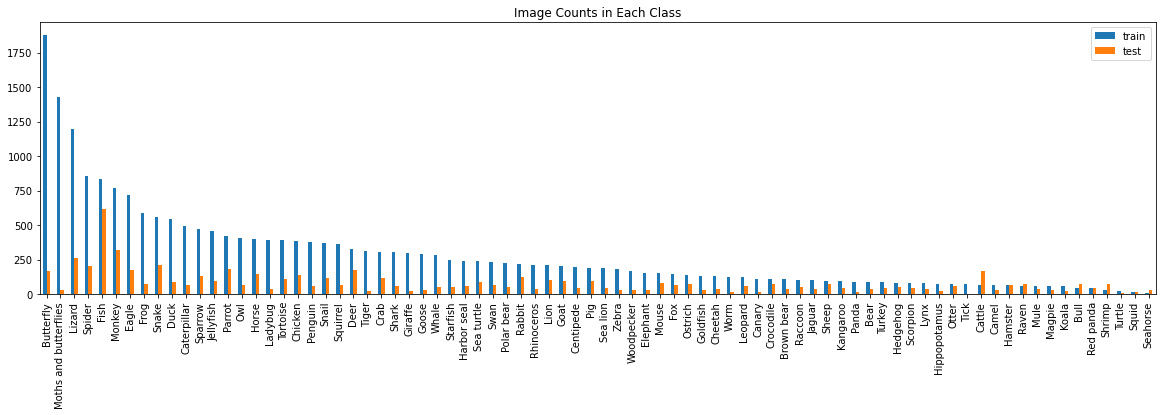

In [8]:
all_data_df=all_data_df.sort_values(by=["train","test"], ascending=False)
all_data_df.plot(kind="bar", legend=True, figsize=(20,5), title="Image Counts in Each Class");


In [9]:
os.makedirs("output", exist_ok=True)

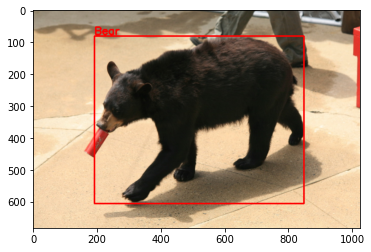

In [10]:
def draw_image(image_file, label_file, class_names):
    class_name = os.path.basename(os.path.dirname(image_file))    
    image = cv2.imread(image_file)
        
    with open(label_file) as fobj:
        while True:            
            item = fobj.readline()
            if item is None or len(item)<=0:
                break
                
            item = item[len(class_name):]
            item = item.split()
            xmin = float(item[0])
            ymin = float(item[1])
            xmax = float(item[2])
            ymax = float(item[3])
        
            image = cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0,0,255), 3)
            image = cv2.putText(image, class_name, (int(xmin), int(ymin-5)), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0, 0, 255), 3)
        
    return image

subdir = all_train_subdir[0]
image_files = glob.glob(os.path.join(subdir, "*.jpg"))

image_file = image_files[0]
label_file = os.path.join(subdir, "Label", os.path.basename(image_file).replace(".jpg", ".txt"))

image = draw_image(image_file, label_file, train_classes)
image = image[:,:,2::-1]
plt.imshow(image);

In [11]:
yolo_train_dir = "yolo/train"
yolo_test_dir = "yolo/test"

for dd in [yolo_train_dir, yolo_test_dir]:
    for ss in ["images", "labels"]:
        print(os.path.join(dd, ss))
        os.makedirs(os.path.join(dd, ss), exist_ok=True)

yolo/train\images
yolo/train\labels
yolo/test\images
yolo/test\labels


In [12]:
yolo_train_dir = "yolo2/train"
yolo_test_dir = "yolo2/test"

for dd in [yolo_train_dir, yolo_test_dir]:
    for ss in ["images", "labels"]:
        print(os.path.join(dd, ss))
        os.makedirs(os.path.join(dd, ss), exist_ok=True)

yolo2/train\images
yolo2/train\labels
yolo2/test\images
yolo2/test\labels


In [13]:
for subdir_id in tqdm(range(len(all_train_subdir))):
    subdir = all_train_subdir[subdir_id]

100%|██████████| 80/80 [00:00<?, ?it/s]


In [14]:
def process_dataset(subdirs, dst_dir, class_names, size=(640,640), link=False):
    for subdir_id in tqdm(range(len(subdirs))):
        subdir = subdirs[subdir_id]
        prefix=os.path.basename(subdir)
        for image_file in glob.glob(os.path.join(subdir, "*.jpg")):
            image_file_basename=os.path.basename(image_file)
            label_file = os.path.join(subdir, "Label", image_file_basename).replace(".jpg", ".txt")
            dst_image_file = os.path.join(dst_dir, "images/%s_%s"%(prefix,image_file_basename))
            dst_label_file = os.path.join(dst_dir, "labels/%s_%s"%(prefix,image_file_basename.replace(".jpg", ".txt")))
            if os.path.exists(dst_label_file):
                continue
                        
            image = cv2.imread(image_file)                
            height, width = image.shape[0:2]
            with open(label_file) as fobj:
                with open(dst_label_file, "w") as wobj:
                    while True:
                        item = fobj.readline()
                        if item is None or len(item)==0:
                            break
                        class_name = prefix
                        item=item[len(class_name):]
                        item = item.split()
                        xmin = float(item[0])
                        ymin = float(item[1])
                        xmax = float(item[2])
                        ymax = float(item[3])

                        cx   = (xmin + xmax)/2.0/width
                        cy   = (ymin + ymax)/2.0/height
                        bw   = (xmax - xmin)/width
                        bh   = (ymax - ymin)/height
                        class_id = class_names.index(class_name)
                        output_line = "%d %f %f %f %f\n"%(class_id, cx, cy, bw, bh)
                        wobj.write(output_line)

            if link==True:
                os.symlink(image_file, dst_image_file)
            else:
                image = cv2.resize(image, size)
                cv2.imwrite(dst_image_file, image)

# process_dataset(all_train_subdir, yolo_train_dir, train_classes, size=(640,640), link=False)        
xueqin_train_subdir=all_train_subdir[0:1]
xueqin_classes=[os.path.basename(pp) for pp in xueqin_train_subdir]

process_dataset(xueqin_train_subdir, yolo_train_dir, xueqin_classes, size=(640,640), link=False)    

100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


In [15]:
xueqin_test_subdir=all_test_subdir[0:1]
process_dataset(xueqin_test_subdir, yolo_test_dir, xueqin_classes, size=(640,640), link=False) 

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


In [16]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -r requirements.txt
%cd -

c:\Users\Ashwin\Projects\Object-Detection-on-Animals\yolov5


Cloning into 'yolov5'...


  Using cached PyYAML-6.0-cp39-cp39-win_amd64.whl (151 kB)
     ------------------------------------- 161.8/161.8 MB 11.1 MB/s eta 0:00:00
     ---------------------------------------- 1.1/1.1 MB 22.5 MB/s eta 0:00:00
  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
     ---------------------------------------- 245.9/245.9 kB ? eta 0:00:00

     ---------------------------------------- 152.9/152.9 kB ? eta 0:00:00
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.6.0
    Uninstalling google-auth-2.6.0:
      Successfully uninstalled google-auth-2.6.0
c:\Users\Ashwin\Projects\Object-Detection-on-Animals


In [17]:
yaml_file="yolov5/data/animal.yaml"
train_images_dir = os.path.join("..", yolo_train_dir, "images")
val_images_dir = os.path.join("..", yolo_test_dir, "images")


names_str=""
for item in xueqin_classes:
    names_str=names_str + ", \'%s\'"%item
names_str= "names: ["+names_str[1:]+"]"

with open(yaml_file, "w") as wobj:
    wobj.write("train: %s\n"%train_images_dir)
    wobj.write("val: %s\n"%val_images_dir)
    wobj.write("nc: %d\n"%len(xueqin_classes))
    wobj.write(names_str+"\n")
    

In [19]:
%pip install -q wandb
import wandb
wandb.login()

Note: you may need to restart the kernel to use updated packages.


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Ashwin/.netrc


True

In [21]:
!python train.py --data data/animal.yaml --batch-size 32 --epochs 10 --img-size 640 --project runs/train --name animals --weights weights/yolov5s.pt --device cpu

^C


Refer to this notebook on how to train further: https://www.kaggle.com/code/yourwanghao/learn-yolov5-on-animal-datasets